Authors: Dennis Kolomiyets 20250762,
         Oussoubi Niakate 20242905,
         Jai 20045247

# Drive Link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS4168PROJECTGROUP12

Mounted at /content/drive
/content/drive/MyDrive/CS4168PROJECTGROUP12


# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.svm import SVR
from sklearn.decomposition import FastICA

# classification algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# metrics for evaluating classification models
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Dataset

In [ ]:
file_path = './steel_industry_data_excerpt.csv'
data = pd.read_csv(file_path)

### Head

In [ ]:
data.head(5)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
0,2018-01-01 02:30:00,3.78,4.72,0.00,0.0,62.51,100.00,9000,Weekday,Monday
1,2018-01-01 04:15:00,3.28,3.82,0.00,0.0,65.14,100.00,15300,Weekday,Monday
2,2018-01-01 05:45:00,3.28,3.49,0.00,0.0,68.48,100.00,20700,Weekday,Monday
3,2018-01-01 10:00:00,3.64,0.00,16.88,0.0,100.00,21.08,36000,Weekday,Monday
4,2018-01-01 10:30:00,3.71,0.00,18.00,0.0,100.00,20.19,37800,Weekday,Monday


### Tail

In [ ]:
data.tail(5)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
2185,2018-12-31 06:45:00,3.02,2.12,0.11,0.0,81.85,99.93,24300,Weekday,Monday
2186,2018-12-31 09:45:00,3.17,0.00,14.65,0.0,100.00,21.15,35100,Weekday,Monday
2187,2018-12-31 13:45:00,3.31,0.00,13.68,0.0,100.00,23.52,49500,Weekday,Monday
2188,2018-12-31 20:00:00,4.14,0.00,20.09,0.0,100.00,20.18,72000,Weekday,Monday
2189,2018-12-31 22:45:00,3.82,4.54,0.00,0.0,64.38,100.00,81900,Weekday,Monday


# Data Preparation

In [ ]:
label_encoder = LabelEncoder()
m = data['Usage_kWh'].mean()
data['Usage_kWh_categorical'] = np.where(data['Usage_kWh'] <= m, 'Low', 'High')
data['Usage_kWh_categorical'] = label_encoder.fit_transform(data['Usage_kWh_categorical'])
y = data['Usage_kWh_categorical']
X = data.drop(['Usage_kWh','date','Usage_kWh_categorical'], axis=1)

In [ ]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("no_outliers", StandardScaler(), ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']),
        ("categorical", OneHotEncoder(sparse_output=False), ['WeekStatus', 'Day_of_week'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [ ]:
X_transformed = preprocess_pipeline.fit_transform(X)

In [ ]:
X_transformed.head(5)

,no_outliers__Lagging_Current_Reactive.Power_kVarh,no_outliers__Leading_Current_Reactive_Power_kVarh,no_outliers__CO2(tCO2),no_outliers__Lagging_Current_Power_Factor,no_outliers__Leading_Current_Power_Factor,no_outliers__NSM,categorical__WeekStatus_Weekday,categorical__WeekStatus_Weekend,categorical__Day_of_week_Friday,categorical__Day_of_week_Monday,categorical__Day_of_week_Saturday,categorical__Day_of_week_Sunday,categorical__Day_of_week_Thursday,categorical__Day_of_week_Tuesday,categorical__Day_of_week_Wednesday
0,-0.531611,-0.527125,-0.731532,-0.983264,0.519599,-1.371186,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.585137,-0.527125,-0.731532,-0.842974,0.519599,-1.117302,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.604763,-0.527125,-0.731532,-0.664812,0.519599,-0.899688,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.812324,1.720222,-0.731532,1.016528,-2.039616,-0.283114,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.812324,1.869335,-0.731532,1.016528,-2.068477,-0.210576,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_transformed.tail(5)

,no_outliers__Lagging_Current_Reactive.Power_kVarh,no_outliers__Leading_Current_Reactive_Power_kVarh,no_outliers__CO2(tCO2),no_outliers__Lagging_Current_Power_Factor,no_outliers__Leading_Current_Power_Factor,no_outliers__NSM,categorical__WeekStatus_Weekday,categorical__WeekStatus_Weekend,categorical__Day_of_week_Friday,categorical__Day_of_week_Monday,categorical__Day_of_week_Saturday,categorical__Day_of_week_Sunday,categorical__Day_of_week_Thursday,categorical__Day_of_week_Tuesday,categorical__Day_of_week_Wednesday
2185,-0.686241,-0.512480,-0.731532,0.048370,0.517329,-0.754612,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2186,-0.812324,1.423327,-0.731532,1.016528,-2.037346,-0.319383,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2187,-0.812324,1.294184,-0.731532,1.016528,-1.960492,0.260922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2188,-0.812324,2.147590,-0.731532,1.016528,-2.068801,1.167648,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2189,-0.542316,-0.527125,-0.731532,-0.883514,0.519599,1.566608,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Here we will attempt four different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Independent Component Analysis (ICA)

### Random Forest Pipeline

A Random Forest classifier bases its final conclusion on the majority vote after each tree has expressed its opinion (prediction) on a given issue. Because each decision tree in the forest is constructed using a distinct and randomly selected subset of the characteristics and data, each tree is unique. Because of this unpredictability, the forest is more diversified and there is less chance of overfitting, which occurs when a model is overly specialized to the training set and underperforms when faced with fresh data. The most frequent result among all the trees is used as the final classification when a new data point has to be categorized. Because of this technique, Random Forest is a strong and reliable tool.

In [ ]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('clf', RandomForestClassifier())
])

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [3, 5, 7]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': [2, 6, 8],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': [2, 6, 8],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.990:
Best parameters:  {'clf__max_depth': 5, 'clf__n_estimators': 50, 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6}


### Support Vector Machine Pipeline

The higher performance of the Support Vector Machine (SVM) classifier across several assessment criteria, such as Accuracy, ROC_AUC, Precision, and F1 score, leads to the conclusion that it beats other models. Higher accuracy and ROC_AUC values are attained using SVM, demonstrating its improved class discrimination and prediction accuracy. Furthermore, SVM exhibits superior accuracy and F1 score, indicating its ability to balance memory and precision in classification tasks. SVM is the most effective classifier for the problem at hand due to its generally greater performance across these critical parameters, even when alternative classifiers may perform better in recall.

In [ ]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('clf', SVC())
])

In [ ]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': [2, 6, 8],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': [2, 6, 8],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

Best CV score = 0.991:
Best parameters:  {'clf__C': 0.1, 'clf__kernel': 'linear', 'reduce_dim': PCA(iterated_power=7, n_components=6), 'reduce_dim__n_components': 6}


### KNN Pipeline


Random k-Nearest Neighbors (kNN) is a simple yet effective classification algorithm. Imagine you have a dataset where each data point is represented by features (like height and weight of a person). To classify a new data point, the algorithm looks at the k nearest data points (neighbors) based on some distance metric (like Euclidean distance) and assigns the majority label among those neighbors to the new data point. The "random" aspect comes in when there's a tie in the majority label: instead of picking the label arbitrarily, it randomly selects one. This randomness helps to reduce bias and ensures a fair decision, making the algorithm robust and less susceptible to noise in the data.

In [ ]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('clf', KNeighborsClassifier())
])

In [ ]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': [2, 6, 8],
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights': ['uniform', 'distance']
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights': ['uniform', 'distance']
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': [2, 6, 8],
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights': ['uniform', 'distance']
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.991:
Best parameters:  {'clf__n_neighbors': 9, 'clf__weights': 'distance', 'reduce_dim': PCA(iterated_power=7, n_components=8), 'reduce_dim__n_components': 8}


### Multi Layer Preceptron Pipeline

A Multi-Layer Perceptron (MLP) Pipeline is a sequence of actions that use MLPs, a kind of deep learning neural network, to analyze and categorize input. Consider MLP as a multilayered neural network, like to the structure of the human brain, in which every neuron at one layer is connected to several neurons at a higher layer. Multiple layers of neurons make up this network: an input layer for data reception, one or more hidden layers for data processing, and an output layer for decision-making or categorization. The process comprises prepping the data (such as scaling or standardizing it), feeding it into the MLP for training, which allows the network to gain decision-making skills by modifying internal parameters, and then applying the learned model to categorize new data. Because of this method's ability to capture intricate patterns in data, MLP is especially useful for applications like picture identification and consumer behavior prediction.

In [ ]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'),
    ('clf', MLPClassifier(max_iter=1000))
])

In [ ]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': [2, 6, 8],
        'clf__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'clf__activation': ['relu', 'tanh'],
        'clf__alpha': [0.0001, 0.001, 0.01]
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto'))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'clf__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'clf__activation': ['relu', 'tanh'],
        'clf__alpha': [0.0001, 0.001, 0.01]
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': [2, 6, 8],
        'clf__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'clf__activation': ['relu', 'tanh'],
        'clf__alpha': [0.0001, 0.001, 0.01]
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
MLPC_best_params = search.best_params_
MLPC_best_model = search.best_estimator_

Best CV score = 0.993:
Best parameters:  {'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (50,), 'reduce_dim': PCA(iterated_power=7, n_components=6), 'reduce_dim__n_components': 6}


## Compare Classification Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- Accuracy
- ROC Score
- Precision
- Recall
- F1 Score

to choose the better classifier for our problem.

In [ ]:
def evaluate_model(X_test, y_test, model):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, roc_auc, precision, recall, f1


In [ ]:
RF_accuracy,RF_roc_auc,RF_precision,RF_recall,RF_f1 = evaluate_model(X_test, y_test, RF_best_model)
SVR_accuracy,SVR_roc_auc,SVR_precision,SVR_recall,SVR_f1 = evaluate_model(X_test, y_test, SVR_best_model)
KNN_accuracy,KNN_roc_auc,KNN_precision,KNN_recall,KNN_f1 = evaluate_model(X_test, y_test, KNN_best_model)
MLPC_accuracy,MLPC_roc_auc,MLPC_precision,MLPC_recall,MLPC_f1 = evaluate_model(X_test, y_test, MLPC_best_model)

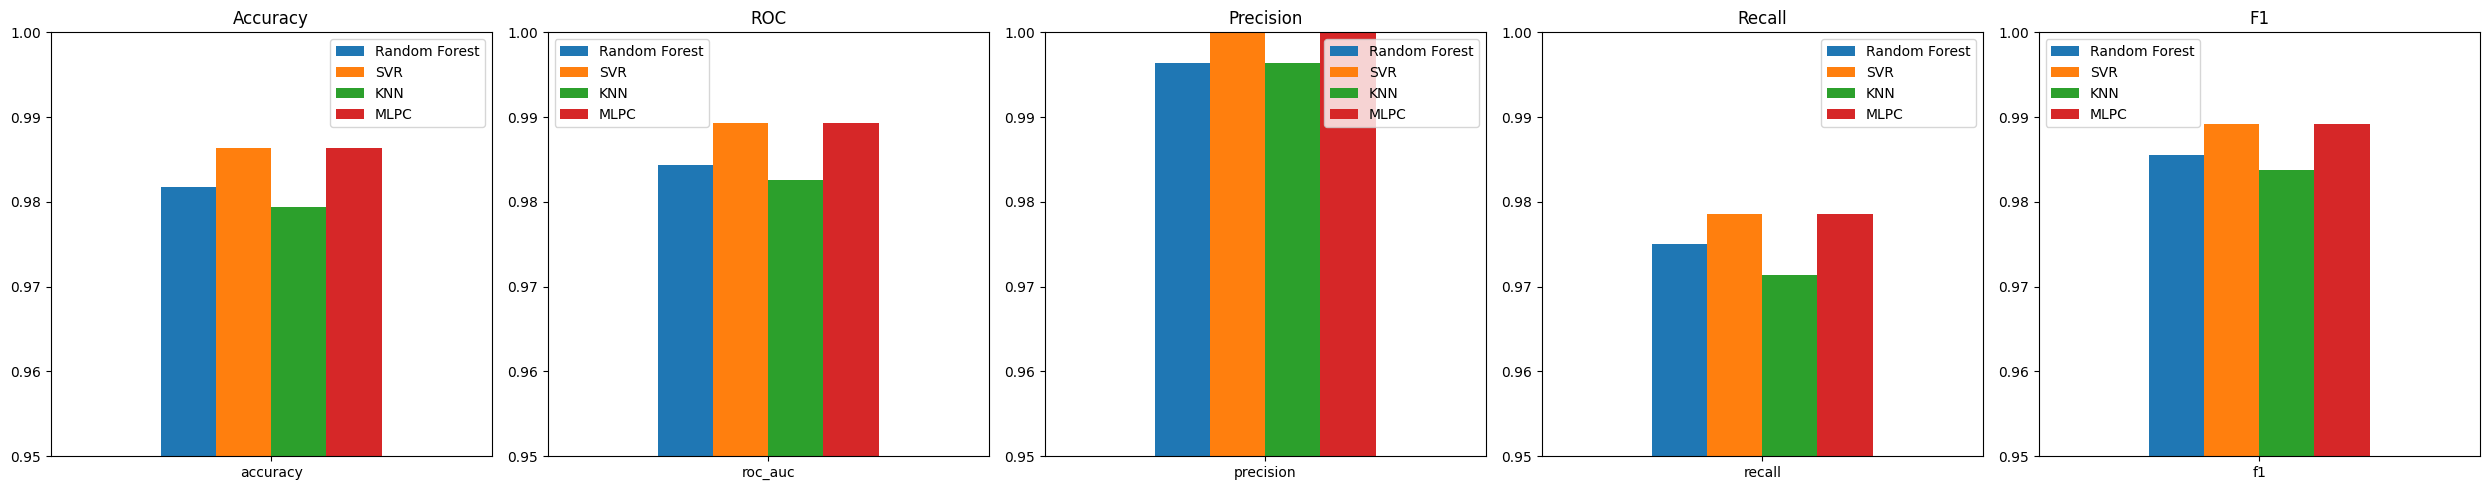

In [ ]:
y_axis_range = {
    'accuracy': (0.95, 1.0),
    'roc_auc': (0.95, 1.0),
    'precision': (0.95, 1.0),
    'recall': (0.95, 1.0),
    'f1': (0.95, 1.0)
}

data_accuracy = pd.DataFrame({'Random Forest': RF_accuracy, 'SVR': SVR_accuracy, 'KNN': KNN_accuracy, 'MLPC': MLPC_accuracy}, index=['accuracy'])
data_roc_auc = pd.DataFrame({'Random Forest': RF_roc_auc, 'SVR': SVR_roc_auc, 'KNN': KNN_roc_auc, 'MLPC': MLPC_roc_auc}, index=['roc_auc'])
data_precision = pd.DataFrame({'Random Forest': RF_precision, 'SVR': SVR_precision, 'KNN': KNN_precision, 'MLPC':MLPC_precision}, index=['precision'])
data_recall = pd.DataFrame({'Random Forest': RF_recall, 'SVR': SVR_recall, 'KNN': KNN_recall, 'MLPC':MLPC_recall}, index=['recall'])
data_f1 = pd.DataFrame({'Random Forest': RF_f1, 'SVR': SVR_f1, 'KNN': KNN_f1, 'MLPC':MLPC_f1}, index=['f1'])


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

data_accuracy.plot.bar(rot=0, ax=axes[0], title='Accuracy', ylim=y_axis_range['accuracy'])
data_roc_auc.plot.bar(rot=0, ax=axes[1], title='ROC', ylim=y_axis_range['roc_auc'])
data_precision.plot.bar(rot=0, ax=axes[2], title='Precision', ylim=y_axis_range['precision'])
data_recall.plot.bar(rot=0, ax=axes[3], title='Recall', ylim=y_axis_range['recall'])
data_f1.plot.bar(rot=0, ax=axes[4], title='F1', ylim=y_axis_range['f1'])

plt.tight_layout()
plt.show()

The tests confirm that Random Forest is the better classifier with higher metrics across Accuracy, ROC_AUC, Precision, and F1 score. While others outperform it in recall overall it is the best

## Train a Final Model

In [ ]:
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline,
                     RF_best_params.get('reduce_dim'),
                     RandomForestClassifier(**transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

Store this model on disk.

In [ ]:
filename = 'final_model_class.sav'
pickle.dump(final_model, open(filename, 'wb'))

New trained model will be stored on disk

###Conclusion

Random Forest performs well in a number of important performance criteria, such as accuracy, ROC_AUC, precision, and F1 score. Therefore it is frequently chosen as the best classifier. These indicators are essential for assessing a model's overall efficacy and dependability in terms of accurately forecasting results and reducing mistakes. Although Random Forest provides a fair trade-off, other classifiers may do better in recall, demonstrating their prowess in detecting all pertinent examples. It is the recommended option for applications that require high dependability and accuracy since it guarantees fewer false positives and a solid overall performance across a variety of circumstances. In the field of machine learning classifiers, Random Forest is a flexible and trustworthy choice because of its harmony of strengths.